# Anomaly Detection Tutorial RCW 2025
Andres, Sid (and special thanks to Tatiana Acero-Cuellar for helping with the Gaia code)

## 0. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lsst.rsp import get_tap_service
from lsst.utils.plotting import (
    get_multiband_plot_colors,
    get_multiband_plot_symbols,
)

service = get_tap_service("tap")
assert service is not None

filter_names = ["u", "g", "r", "i", "z", "y"]
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

## 1. Query Photometric Data

In [3]:
query = """
SELECT
    diaObjectId, ra, dec,
    g_psfFluxMean, g_psfFluxSigma, g_psfFluxNdata, g_psfFluxLinearSlope,
    r_psfFluxMean, r_psfFluxSigma, r_psfFluxNdata, r_psfFluxLinearSlope,
    i_psfFluxMean, i_psfFluxSigma, i_psfFluxNdata, i_psfFluxLinearSlope
FROM
    dp1.DiaObject
WHERE
    r_psfFluxNdata > 5
    AND r_scienceFluxMean < 100000
"""

job = service.submit_job(query)
job.run()
job.wait(phases=["COMPLETED", "ERROR"])
if job.phase == "ERROR":
    job.raise_if_error()

assert job.phase == "COMPLETED"
dia_objects = job.fetch_result().to_table().to_pandas().set_index("diaObjectId")

print(f"Retrieved {len(dia_objects)} DiaObjects.")

Retrieved 16704 DiaObjects.


In [52]:
sample = (
    dia_objects[
        [
            # "g_psfFluxMean",
            # "g_psfFluxLinearSlope",
            # "g_psfFluxSigma",
            "r_psfFluxMean",
            "r_psfFluxLinearSlope",
            "r_psfFluxSigma",
            # "i_psfFluxMean",
            # "i_psfFluxLinearSlope",
            # "i_psfFluxSigma",
        ]
    ]
    .values
)

## 2. Run Isolation Forest

Add some explanation of how IF works.

e.g. from Sid's graphic:
![](tmp.gif)

In [53]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)
ifo = IsolationForest(max_samples=500, random_state=rng, n_jobs=1)
ifo.fit(sample)

,n_estimators,100
,max_samples,500
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,1
,random_state,RandomState(M...0x7A1F6B15FD40
,verbose,0
,warm_start,False


In [78]:
scores = ifo.score_samples(sample)
outlier_indices = np.argsort(scores)[:20]

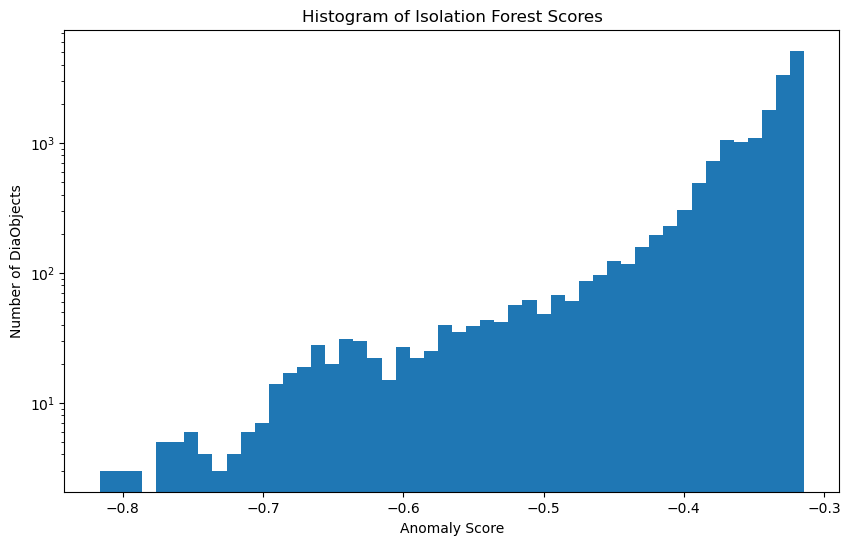

In [55]:
plt.figure(figsize=(10, 6))
plt.title("Histogram of Isolation Forest Scores")
plt.hist(scores, bins=50, log=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Number of DiaObjects")
plt.show()

In [56]:
outlier_diaobject_ids = dia_objects.index[outlier_indices]

In [57]:
query_lightcurves = f"""
SELECT
    fsodo.diaObjectId,
    fsodo.band,
    fsodo.psfDiffFlux,
    fsodo.psfDiffFluxErr,
    vis.expMidptMJD
FROM
    dp1.ForcedSourceOnDiaObject AS fsodo
JOIN
    dp1.Visit AS vis ON vis.visit = fsodo.visit
WHERE
    fsodo.diaObjectId IN ({','.join(map(str, outlier_diaobject_ids))})
"""

job_lightcurves = service.submit_job(query_lightcurves)
job_lightcurves.run()
job_lightcurves.wait(phases=["COMPLETED", "ERROR"])
if job_lightcurves.phase == "ERROR":
    job_lightcurves.raise_if_error()

assert job_lightcurves.phase == "COMPLETED"
forced_source_outliers = job_lightcurves.fetch_result().to_table().to_pandas()

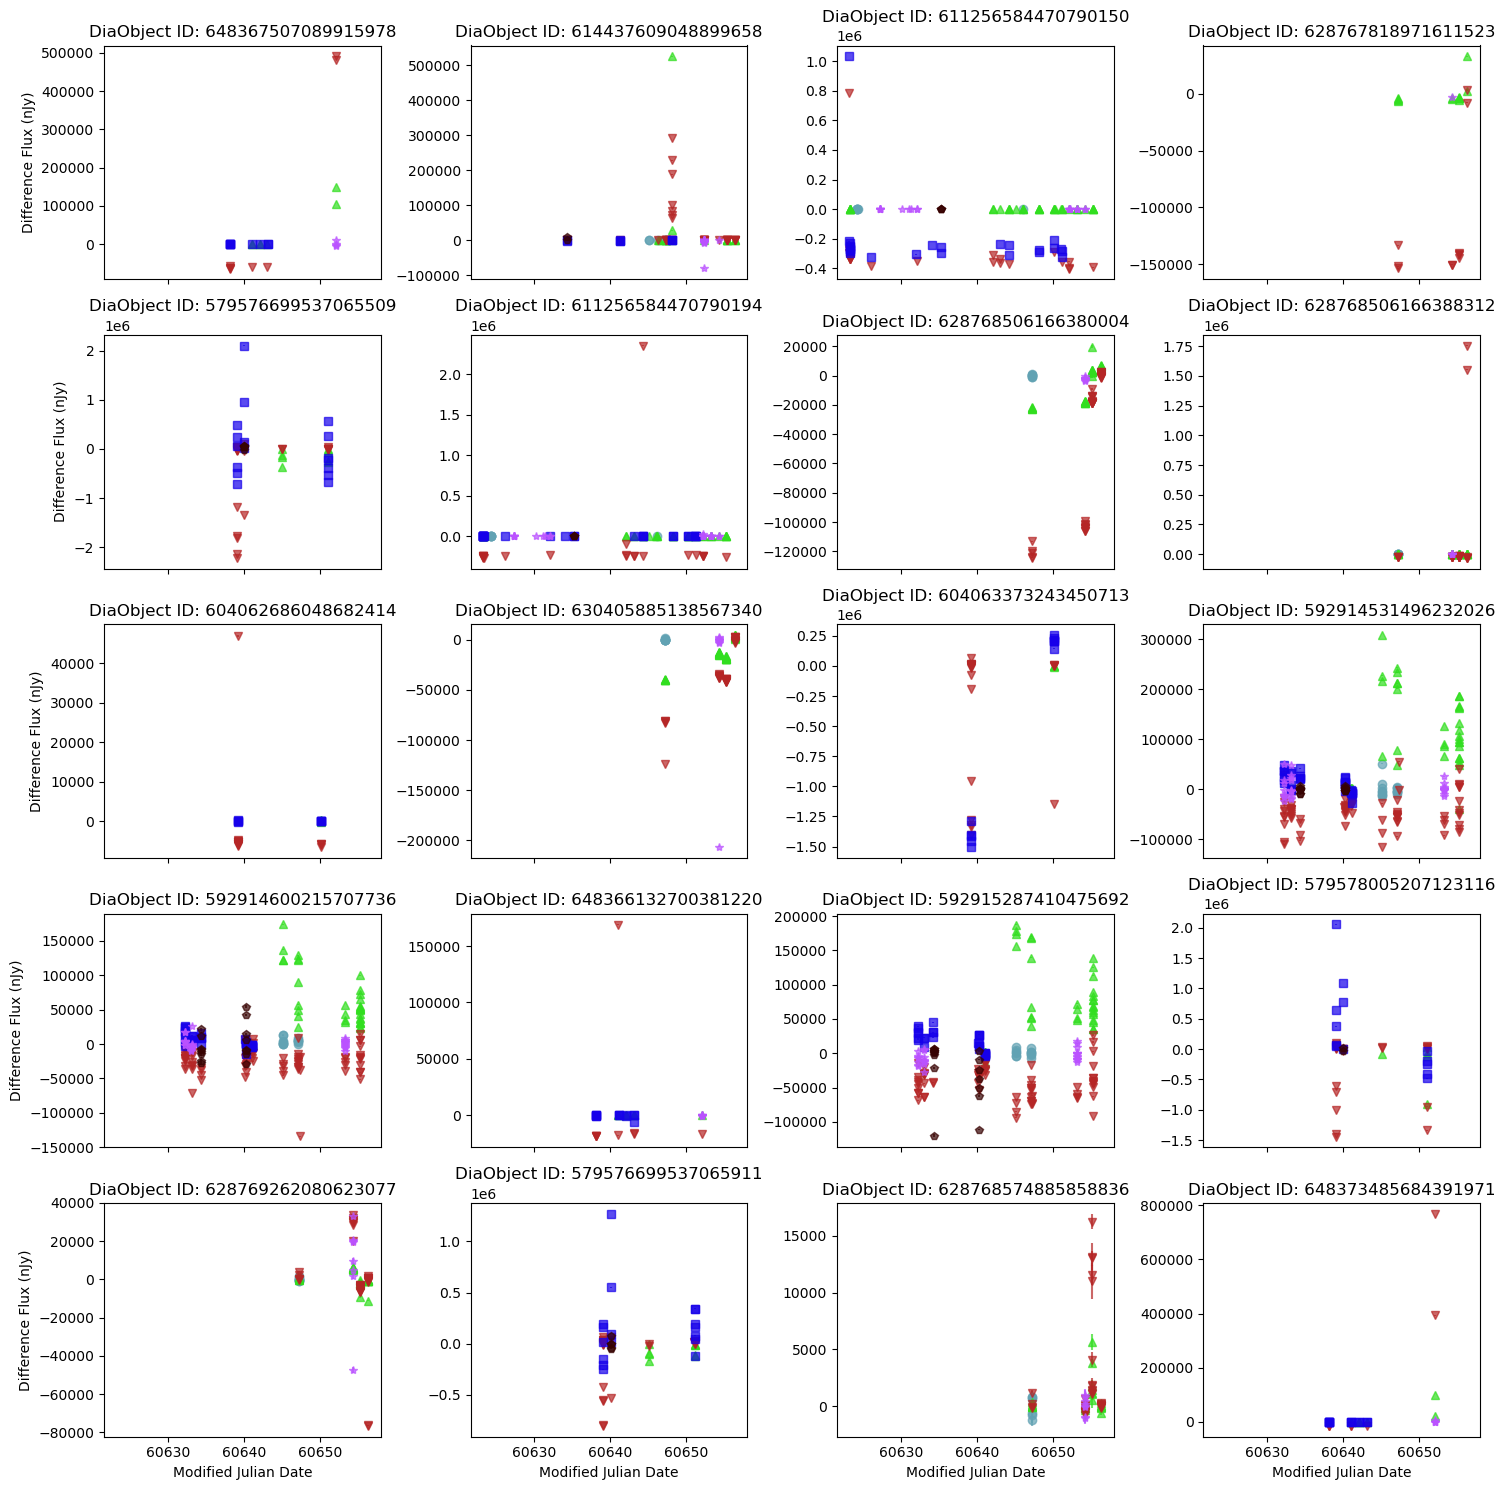

In [58]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, diaobject_id in enumerate(outlier_diaobject_ids):
    ax = axes[i]
    object_data = forced_source_outliers[
        forced_source_outliers["diaObjectId"] == diaobject_id
    ]
    for band in filter_names:
        band_data = object_data[object_data["band"] == band]
        if len(band_data) > 0:
            ax.errorbar(
                band_data["expMidptMJD"],
                band_data["psfDiffFlux"],
                yerr=band_data["psfDiffFluxErr"],
                fmt=filter_symbols[band],
                color=filter_colors[band],
                label=band,
                alpha=0.7,
            )
    ax.set_title(f"DiaObject ID: {diaobject_id}")
    if i >= 16:
        ax.set_xlabel("Modified Julian Date")
    if i % 4 == 0:
        ax.set_ylabel("Difference Flux (nJy)")

plt.tight_layout()
plt.show()

Add comments about analysis

In [59]:
top_outlier_id = outlier_diaobject_ids[0]
top_outlier_data = dia_objects.loc[top_outlier_id]
print("Top Outlier")
print(f"  DiaObject ID: {top_outlier_data.index[0]}")
print(f"  RA: {top_outlier_data['ra']}")
print(f"  Dec: {top_outlier_data['dec']}")
print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")

Top Outlier
  DiaObject ID: ra
  RA: 37.99417473077787
  Dec: 7.2739802663929956
  r-band PSF Flux Mean: -44337.1875
  r-band PSF Flux Sigma: 282457.5359111508
  r-band PSF Flux Linear Slope: 25423.938938181407


## 3. Run DistClassiPy: Anomalies

Maybe add graphic.

In [60]:
!pip install git+http://github.com/sidchaini/distclassipy
# pip install distclassipy

Defaulting to user installation because normal site-packages is not writeable
  Cloning http://github.com/sidchaini/distclassipy to /tmp/pip-req-build-i58da74f
  Running command git clone --filter=blob:none --quiet http://github.com/sidchaini/distclassipy /tmp/pip-req-build-i58da74f
  Resolved http://github.com/sidchaini/distclassipy to commit dbd4d98dc1a8aad8f02bfa622dc3c46766fa211a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [61]:
from distclassipy.anomaly import DistanceAnomaly

Now, we also need some labels for DistClassiPy to find an anchor to "known" classes. We can do this by cross matching DP1 with Gaia data (see ```2. gaia dp1 xmatch.ipynb```).

Here, let's load the cross match table generated in the other notebook.

In [62]:
# features = pd.read_parquet("../dp1anom/data/dp1_features_sc.parquet")
gaia_xmatch = pd.read_csv("gaia_matches.csv").set_index("diaObjectId")

In [63]:
common_objs = np.intersect1d(gaia_xmatch.index, dia_objects.index)
print(f"Found {len(common_objs)} objects common in Gaia DR3 and DP1")
gaia_classes = gaia_xmatch.loc[common_objs,["best_class_name"]].reset_index(drop=False).drop_duplicates().set_index("diaObjectId")

Found 160 objects common in Gaia DR3 and DP1


In [64]:
gaia_classes.value_counts()

best_class_name
RR                 43
AGN                38
LPV                38
SOLAR_LIKE         17
ECL                11
RS                  5
YSO                 5
S                   3
Name: count, dtype: int64

In [71]:
y_knowns_df = gaia_classes["best_class_name"]
X_knowns_df = dia_objects.loc[y_knowns_df.index,
    [
        "r_psfFluxMean",
        "r_psfFluxLinearSlope",
        "r_psfFluxSigma",
    ]
]

In [72]:
X_unknowns_df = dia_objects.loc[:,X_knowns_df.columns].drop(X_knowns_df.index)

In [73]:
model = DistanceAnomaly(
    cluster_agg='min',
    metric_agg='median',
    normalize_scores=True
)

In [75]:
model.fit(X_knowns_df.to_numpy(), y_knowns_df.to_numpy())

,metrics,None
,cluster_agg,'min'
,metric_agg,'median'
,normalize_scores,True
,scale,True
,central_stat,'median'
,dispersion_stat,'std'
,contamination,0.1


In [84]:
scores = -model.decision_function(X_unknowns_df.to_numpy())
outlier_indices = np.argsort(scores)[:20]

In [85]:
outlier_indices = np.argsort(scores)[:20]

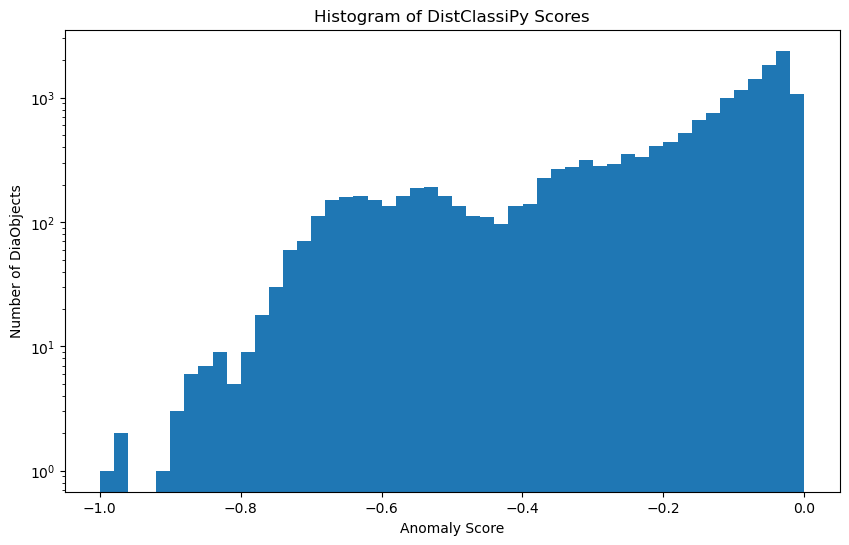

In [86]:
plt.figure(figsize=(10, 6))
plt.title("Histogram of DistClassiPy Scores")
plt.hist(scores, bins=50, log=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Number of DiaObjects")
plt.show()

In [87]:
outlier_diaobject_ids = dia_objects.index[outlier_indices]

In [88]:
query_lightcurves = f"""
SELECT
    fsodo.diaObjectId,
    fsodo.band,
    fsodo.psfDiffFlux,
    fsodo.psfDiffFluxErr,
    vis.expMidptMJD
FROM
    dp1.ForcedSourceOnDiaObject AS fsodo
JOIN
    dp1.Visit AS vis ON vis.visit = fsodo.visit
WHERE
    fsodo.diaObjectId IN ({','.join(map(str, outlier_diaobject_ids))})
"""

job_lightcurves = service.submit_job(query_lightcurves)
job_lightcurves.run()
job_lightcurves.wait(phases=["COMPLETED", "ERROR"])
if job_lightcurves.phase == "ERROR":
    job_lightcurves.raise_if_error()

assert job_lightcurves.phase == "COMPLETED"
forced_source_outliers = job_lightcurves.fetch_result().to_table().to_pandas()

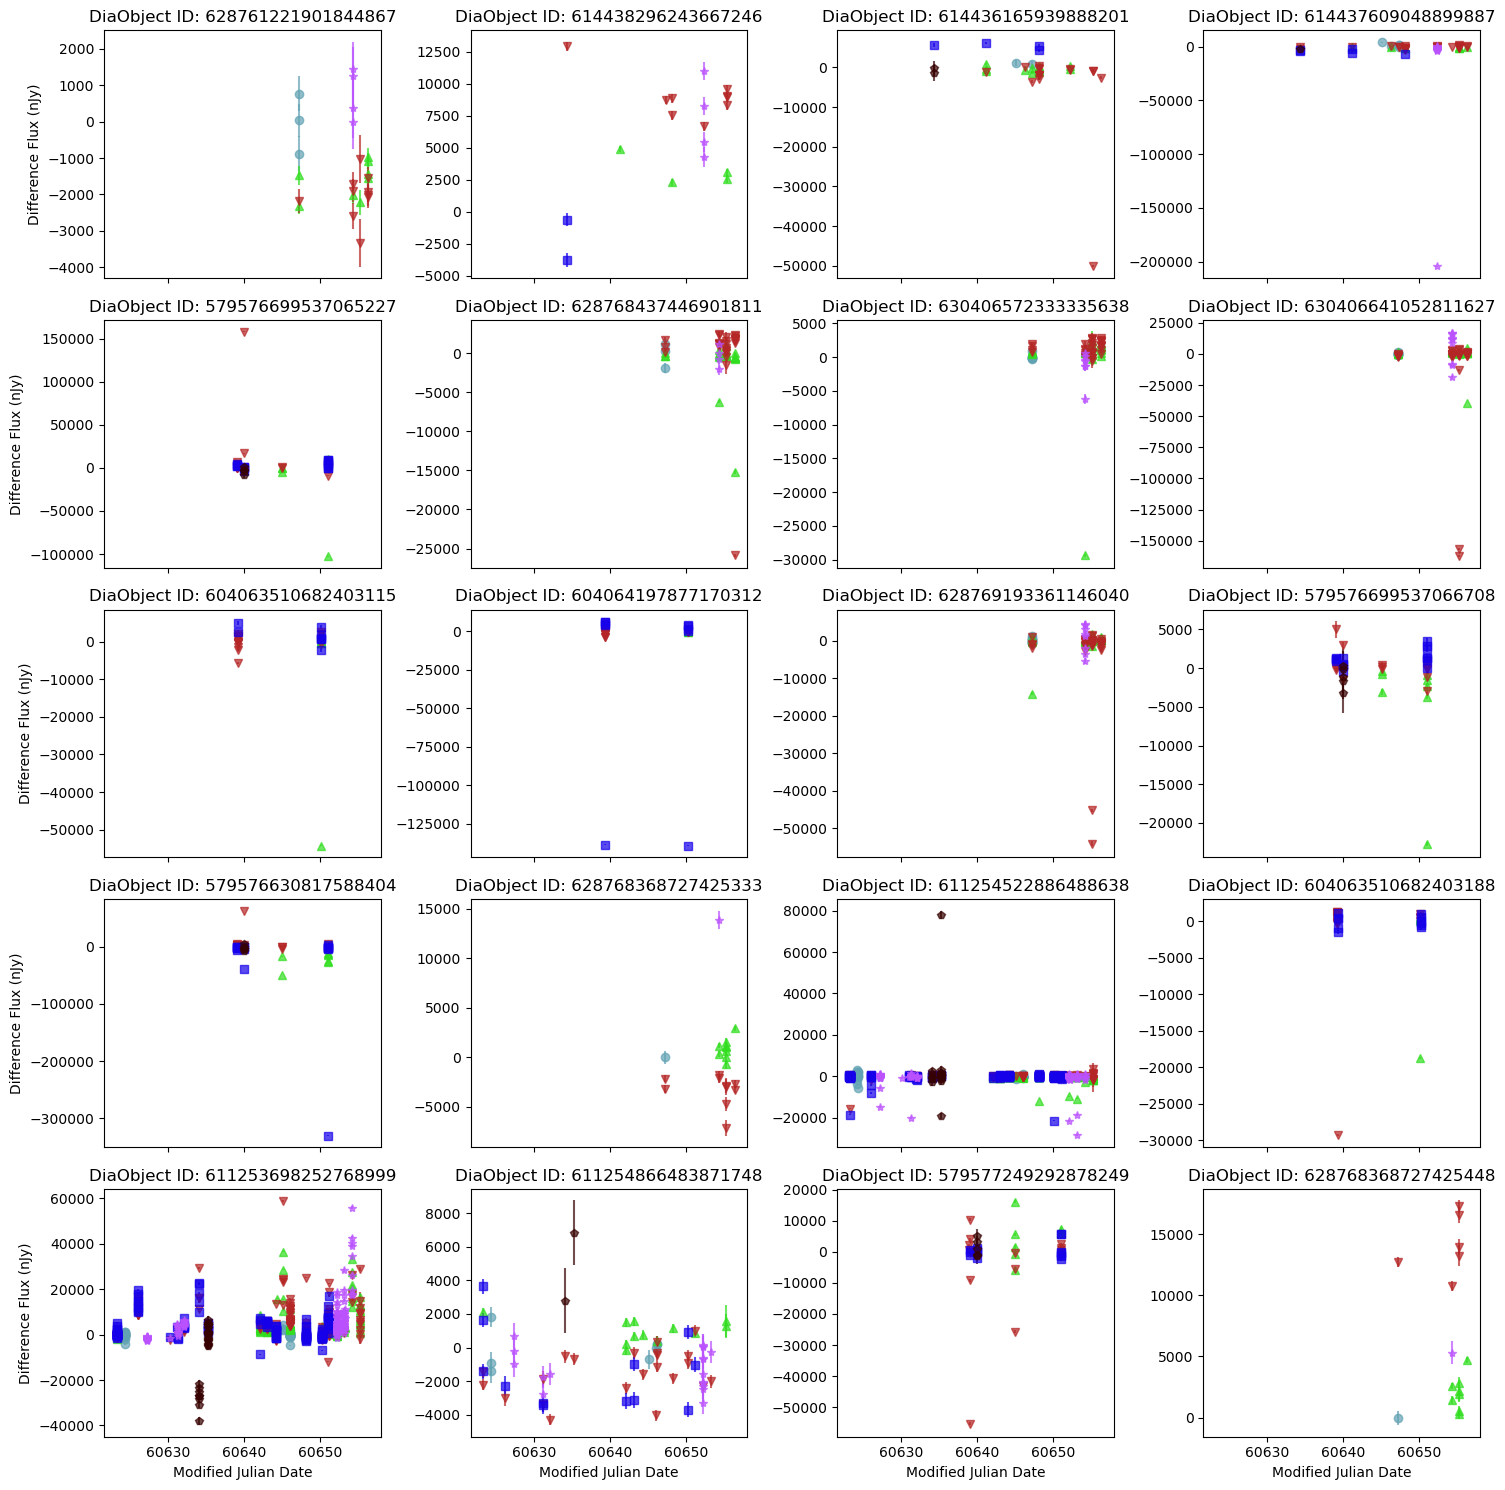

In [89]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, diaobject_id in enumerate(outlier_diaobject_ids):
    ax = axes[i]
    object_data = forced_source_outliers[
        forced_source_outliers["diaObjectId"] == diaobject_id
    ]
    for band in filter_names:
        band_data = object_data[object_data["band"] == band]
        if len(band_data) > 0:
            ax.errorbar(
                band_data["expMidptMJD"],
                band_data["psfDiffFlux"],
                yerr=band_data["psfDiffFluxErr"],
                fmt=filter_symbols[band],
                color=filter_colors[band],
                label=band,
                alpha=0.7,
            )
    ax.set_title(f"DiaObject ID: {diaobject_id}")
    if i >= 16:
        ax.set_xlabel("Modified Julian Date")
    if i % 4 == 0:
        ax.set_ylabel("Difference Flux (nJy)")

plt.tight_layout()
plt.show()

Add comments about analysis

In [91]:
top_outlier_id = outlier_diaobject_ids[0]
top_outlier_data = dia_objects.loc[top_outlier_id]
print("Top Outlier")
print(f"  DiaObject ID: {top_outlier_data.index[0]}")
print(f"  RA: {top_outlier_data['ra']}")
print(f"  Dec: {top_outlier_data['dec']}")
print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")

Top Outlier
  DiaObject ID: ra
  RA: 105.89437507631412
  Dec: -10.780733175414959
  r-band PSF Flux Mean: -2001.93603515625
  r-band PSF Flux Sigma: 320.62485203153324
  r-band PSF Flux Linear Slope: 46.149397520886595


## 4. Going further

Now, in this tutorial we only used photometric data available from the catalogs. For more detailed analysis, you could use a feature extractor on every light curve. For example: [ALeRCE](https://github.com/alercebroker/pipeline)([Sánchez-Sáez+21](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract)) or [```light-curve```]((https://github.com/light-curve/light-curve-python))[(Malanchev+21)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.5147M/abstract).

After obtaining these features for your light curve sample, you can perform anomaly detection very similarly to above.